In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df1 = pd.read_csv('trips_2018_cleaned.csv',index_col=0)

In [2]:
df1.head()

,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week
tripduration,,,,,,,,,,,,,,,,,,
970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992,1,970.752,2018-01-01,13,Monday,1,1
723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969,1,723.159,2018-01-01,15,Monday,1,1
496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956,1,496.835,2018-01-01,15,Monday,1,1
306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974,1,306.819,2018-01-01,15,Monday,1,1
306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992,1,306.074,2018-01-01,18,Monday,1,1


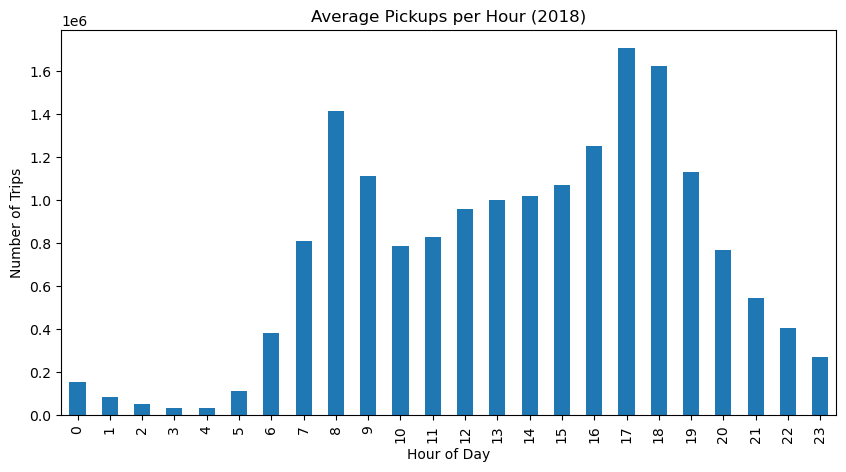

In [4]:
hourly = df1.groupby('hour').size()
plt.figure(figsize=(10,5))
hourly.plot(kind='bar')
plt.title("Average Pickups per Hour (2018)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

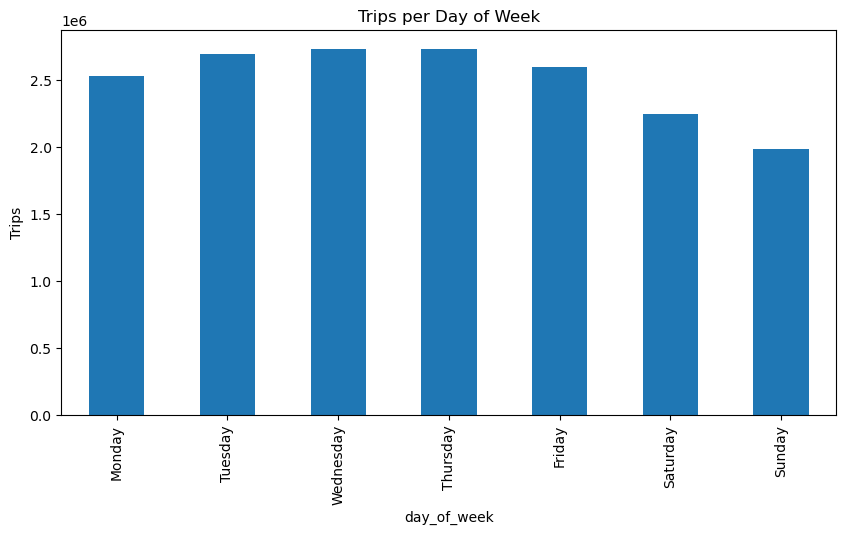

In [5]:
weekly = df1.groupby('day_of_week').size().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

plt.figure(figsize=(10,5))
weekly.plot(kind='bar')
plt.title("Trips per Day of Week")
plt.ylabel("Trips")
plt.show()


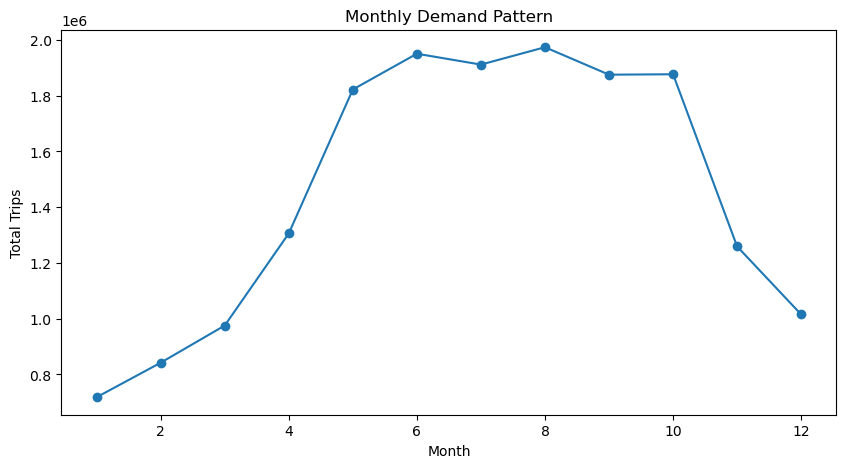

In [6]:
monthly = df1.groupby('month').size()

plt.figure(figsize=(10,5))
monthly.plot(kind='line', marker='o')
plt.title("Monthly Demand Pattern")
plt.xlabel("Month")
plt.ylabel("Total Trips")
plt.show()